# Image Classifier

## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import datasets, transforms
import torch.utils
import torch.utils.data 
import torch.utils.data.dataloader


In [26]:
print(torch.__version__)

2.2.2


In [27]:
print(f"Is MPS built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Is MPS built? True
Is MPS available? True
Using device: mps


In [28]:
x = torch.rand(size=(3, 4)).to(device)
x

tensor([[0.7332, 0.5583, 0.3387, 0.2606],
        [0.1704, 0.7227, 0.0747, 0.8420],
        [0.2226, 0.5101, 0.0480, 0.3565]], device='mps:0')

## Data

In [29]:
folderpath= 'data/segmented/graph/pl'
#folderpath= '/Users/davidpichler/MT_Repo/test_db/Vocal_files/pl'

transform = transforms.Compose([transforms.Resize((300, 300)),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

dataset = datasets.ImageFolder(folderpath, transform=transform)

batchSize = 16

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True, num_workers=4)

torch.Size([3, 224, 224])
Dataset ImageFolder
    Number of datapoints: 29892
    Root location: /Users/davidpichler/MT_Repo/test_db/Batch 3/pl
    StandardTransform
Transform: Compose(
               Resize(size=(300, 300), interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
           )
{'corrected': 0, 'original': 1, 'smoothed': 2}


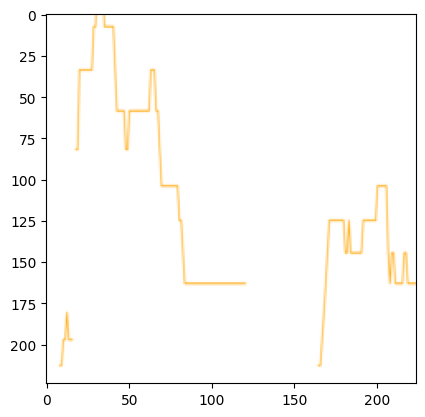

In [30]:
img, labels = dataset[3000]
print(img.shape)
plt.imshow(img.permute(1,2,0))
print(dataset)
print(dataset.class_to_idx)

In [31]:
images_batch, labels_batch = next(iter(dataloader))
images_batch.shape

torch.Size([16, 3, 224, 224])

In [32]:
labels_batch.shape

torch.Size([16])

In [33]:
labels_batch

tensor([1, 0, 0, 1, 0, 2, 2, 1, 0, 0, 0, 0, 1, 2, 0, 2])

In [34]:
img = torchvision.utils.make_grid(images_batch)

In [35]:
img.shape

torch.Size([3, 454, 1810])

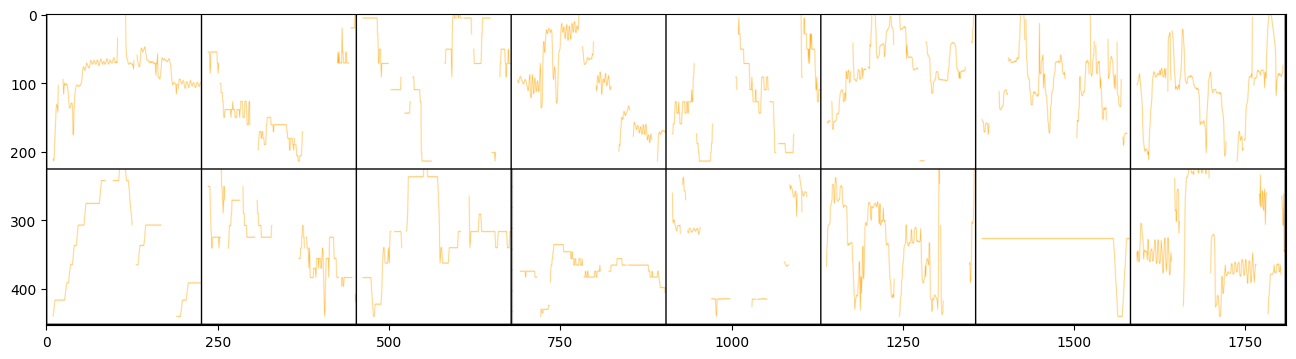

In [36]:
img = np.transpose(img, (1, 2, 0))
plt.figure(figsize=(16, 12))
plt.imshow(img)

In [37]:
from torch.utils.data import random_split

random_seed = 2021
torch.manual_seed(random_seed)

# Define the sizes of the train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset into train and test sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print('Train Dataset: ' + str(len(train_dataset)))
print('Test Dataset: ' + str(len(test_dataset)))

# Create dataloaders for train and test sets


Train Dataset: 23913
Test Dataset: 5979


## CNN

In [38]:
import torch.nn as nn
import torch.nn.functional as F

In [39]:
in_size = 3 # RGB images

hid1_size = batchSize # number of filters
hid2_size = hid1_size * 2  # number of filters
hid3_size = hid2_size * 2  # number of filters

out_size = 3 # num of classes

k_conv_size = 3 # conv kernel size


In [40]:

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batchSize, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batchSize, shuffle=True, num_workers=4)

In [ ]:
class ConvNet(nn.Module):    
    """
    A Convolutional Neural Network (CNN) for image classification.
    Attributes:
    -----------
    layer1 : nn.Sequential
        The first convolutional layer followed by batch normalization, ELU activation, and max pooling.
    layer2 : nn.Sequential
        The second convolutional layer followed by batch normalization, ELU activation, and max pooling.
    layer3 : nn.Sequential
        The third convolutional layer followed by batch normalization, ELU activation, and max pooling.
    flatten : nn.Flatten
        Layer to flatten the input tensor.
    dropout : nn.Dropout
        Dropout layer with a probability of 0.2.
    fc1 : nn.Linear
        The first fully connected layer.
    fc2 : nn.Linear
        The second fully connected layer.
    fc3 : nn.Linear
        The third fully connected layer which outputs the final predictions.
    Methods:
    --------
    forward(x)
        Defines the forward pass of the network.
    """
    # Constructor
    def __init__(self):
        super(ConvNet, self).__init__()

        # Convolution 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_size, hid1_size, kernel_size=k_conv_size),
            nn.BatchNorm2d(hid1_size),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2))
        
        # Convolution 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(hid1_size, hid2_size, kernel_size=k_conv_size),
            nn.BatchNorm2d(hid2_size),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2))
        
        # Convolution 3
        self.layer3 = nn.Sequential(
            nn.Conv2d(hid2_size, hid3_size, kernel_size=k_conv_size),
            nn.BatchNorm2d(hid3_size),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2))
        
        # Flatten
        self.flatten = nn.Flatten()

        # Dropout
        self.dropout = nn.Dropout(0.2)

        # Fully connected 1
        self.fc1 = nn.Linear(43264, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, out_size)
    
    # Prediction
    def forward(self, x):
        out = self.layer1(x) # conv1
        out = self.layer2(out) # conv2
        out = self.layer3(out) # conv3
        out = self.flatten(out) # flatten
        out = self.dropout(out) # dropout
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
 
        return out

In [ ]:
class ConvNet(nn.Module):    
    """
    A Convolutional Neural Network (CNN) for image classification.
    Attributes:
    -----------
    layer1 : nn.Sequential
        The first convolutional layer followed by batch normalization, ELU activation, and max pooling.
    layer2 : nn.Sequential
        The second convolutional layer followed by batch normalization, ELU activation, and max pooling.
    layer3 : nn.Sequential
        The third convolutional layer followed by batch normalization, ELU activation, and max pooling.
    flatten : nn.Flatten
        Layer to flatten the input tensor.
    dropout : nn.Dropout
        Dropout layer with a probability of 0.2.
    fc1 : nn.Linear
        The first fully connected layer.
    fc2 : nn.Linear
        The second fully connected layer.
    fc3 : nn.Linear
        The third fully connected layer which outputs the final predictions.
    Methods:
    --------
    forward(x)
        Defines the forward pass of the network.
    """
    # Constructor
    def __init__(self):
        super(ConvNet, self).__init__()

        # Convolution 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_size, hid1_size, kernel_size=k_conv_size),
            nn.BatchNorm2d(hid1_size),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2))
        
        # Convolution 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(hid1_size, hid2_size, kernel_size=k_conv_size),
            nn.BatchNorm2d(hid2_size),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2))
        
        # Convolution 3
        self.layer3 = nn.Sequential(
            nn.Conv2d(hid2_size, hid3_size, kernel_size=k_conv_size),
            nn.BatchNorm2d(hid3_size),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2))
        
        # Flatten
        self.flatten = nn.Flatten()

        # Dropout
        self.dropout = nn.Dropout(0.2)

        # Fully connected 1
        self.fc1 = nn.Linear(43264, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, out_size)
    
    # Prediction
    def forward(self, x):
        out = self.layer1(x) # conv1
        out = self.layer2(out) # conv2
        out = self.layer3(out) # conv3
        out = self.flatten(out) # flatten
        out = self.dropout(out) # dropout
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
 
        return out

In [42]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(25088, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the basic block for ResNet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Define the ResNet-18 model
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [44]:
model = ConvNet()
model = model.to(device)

In [45]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [46]:
num_epochs = 10

acc = []
loss_values = []

In [47]:
def validate(model, loader):
    correct = 0
    total = 0
    
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            # Send data to device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    return correct / total

In [48]:
# Lists to store predictions and true labels
all_preds = []
all_labels = []

for epoch in range(num_epochs):
    model.train()
    for img, labels in train_loader: 
        img, labels = img.to(device), labels.to(device)
        
        outputs = model(img)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store predictions and true labels
        all_preds.extend(outputs.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

    train_accuracy = validate(model, train_loader)
        
    loss_values.append(loss.item())
    acc.append(train_accuracy)

    #if epoch % 5 == 0: 
    print(f'Epoch: {epoch + 1} | Loss: {loss.item()}' + f' | Train Accuracy:  {train_accuracy}')

test_acc = validate(model, test_loader)
print(f'Test Accuracy: {test_acc}')

Epoch: 1 | Loss: 1.016327142715454 | Train Accuracy:  0.3362187931250784
Epoch: 2 | Loss: 0.4826545715332031 | Train Accuracy:  0.6301175093045623
Epoch: 3 | Loss: 2.118196964263916 | Train Accuracy:  0.33366787939614434
Epoch: 4 | Loss: 2.83345365524292 | Train Accuracy:  0.3348806088738343
Epoch: 5 | Loss: 0.20236068964004517 | Train Accuracy:  0.8078451051729185
Epoch: 6 | Loss: 0.18113330006599426 | Train Accuracy:  0.3442060803746916
Epoch: 7 | Loss: 0.16249534487724304 | Train Accuracy:  0.4104462008112742
Epoch: 8 | Loss: 0.1151927039027214 | Train Accuracy:  0.3348806088738343
Epoch: 9 | Loss: 0.0024073475506156683 | Train Accuracy:  0.3545770083218333
Epoch: 10 | Loss: 0.1435108482837677 | Train Accuracy:  0.6275247773177769
Test Accuracy: 0.6253554106037799


## Evaluation

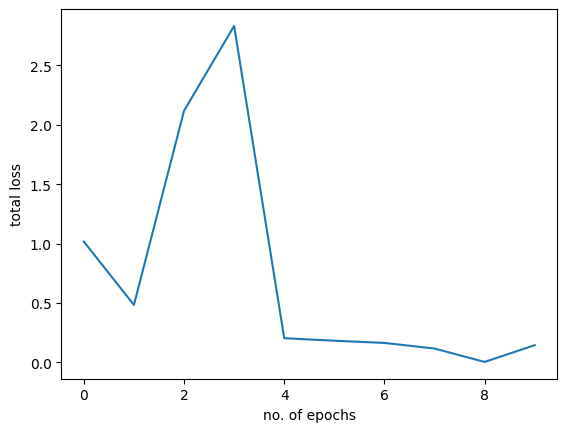

In [49]:
plt.plot(loss_values)
plt.xlabel("no. of epochs")
plt.ylabel("total loss")
plt.show()

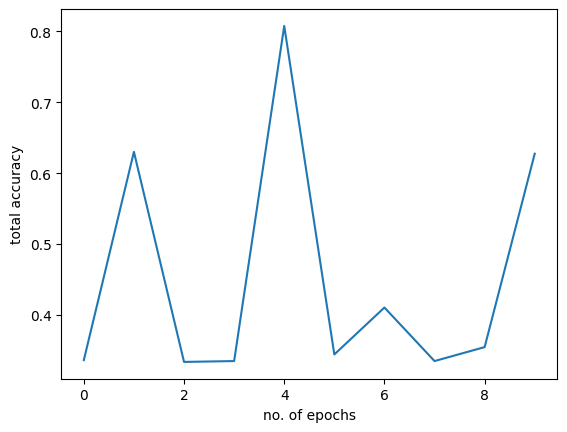

In [50]:
plt.plot(acc)
plt.xlabel("no. of epochs")
plt.ylabel("total accuracy")
plt.show()

In [51]:
from sklearn.metrics import f1_score
from itertools import groupby

# Set the model to evaluation mode
model.eval()

# Turn off gradients
with torch.no_grad():
   correct = 0
   total = 0
   true_labels = []
   predicted_labels = []
   acc = []
   fScore = []

   for X_test_tensor, Y_test_tensor in test_loader:
      X_test_tensor, Y_test_tensor = X_test_tensor.to(device), Y_test_tensor.to(device)
      outputs = model(X_test_tensor)
      _, predicted = torch.max(outputs.data, 1)

      y_test = Y_test_tensor.cpu().numpy()
      predicted = predicted.cpu().numpy()

      correct += (predicted == y_test).sum().item()
      total += len(y_test)

      #print(true_labels)
      true_labels.extend(y_test)
      #print(predicted_labels)
      predicted_labels.extend(predicted)

   #print(predicted_labels)
   #print(true_labels)

   unique, counts = np.unique(predicted_labels, return_counts=True)

   print(f'Predicted labels: {dict(zip(unique, counts))}')

   unique, counts = np.unique(true_labels, return_counts=True)
   print(f'True labels: {dict(zip(unique, counts))}')

   accuracy = correct / total
   #acc.append(accuracy)

   #f1 = f1_score(true_labels, predicted_labels)
   #fScore.append(f1)

   print(f'Accuracy: {accuracy}')

   #print(f'F1 Score: {f1}')


Predicted labels: {0: 1709, 2: 4270}
True labels: {0: 1985, 1: 1956, 2: 2038}
Accuracy: 0.6253554106037799


In [52]:
import pandas as pd
from sklearn.metrics import confusion_matrix

# Create a DataFrame from the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cm_df = pd.DataFrame(cm, index=['Actual Corrected', 'Actual Original', 'Actual Smoothed'], columns=['Predicted Corrected', 'Predicted Original', 'Predicted Smoothed'])

# Display the DataFrame
print(cm_df)


                  Predicted Corrected  Predicted Original  Predicted Smoothed
Actual Corrected                 1703                   0                 282
Actual Original                     4                   0                1952
Actual Smoothed                     2                   0                2036


In [53]:
import shap

batch = next(iter(test_loader))
images, labesl = batch

background = images[:28]
test_images = images[29:32]

print(background.shape)
print(test_images.shape)

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

/Users/davidpichler/MT_Repo/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([16, 3, 224, 224])
torch.Size([0, 3, 224, 224])


RuntimeError: Input type (torch.FloatTensor) and weight type (MPSFloatType) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


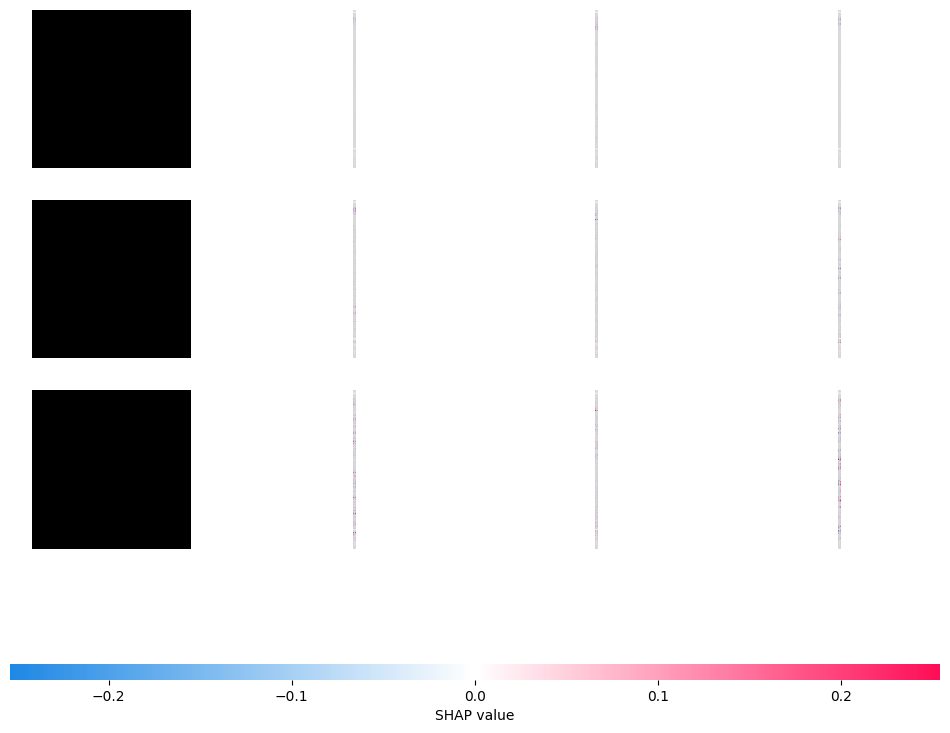

In [ ]:
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)


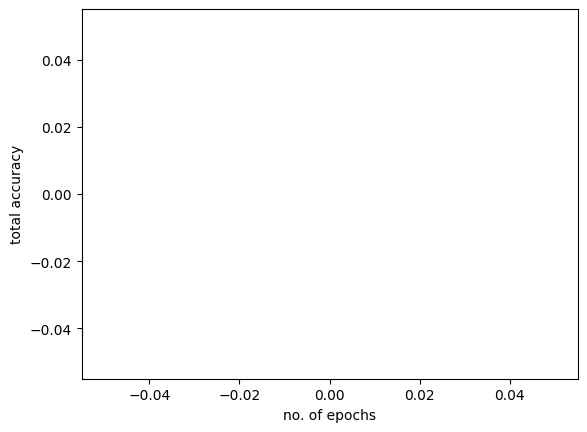

In [ ]:
plt.plot(acc)
plt.xlabel("no. of epochs")
plt.ylabel("total accuracy")
plt.show()

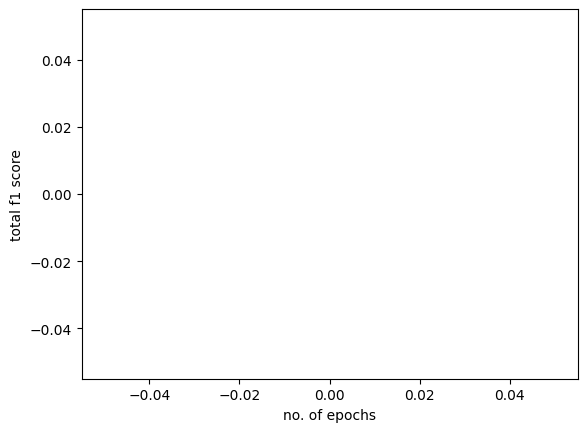

In [ ]:
plt.plot(fScore)
plt.xlabel("no. of epochs")
plt.ylabel("total f1 score")
plt.show()

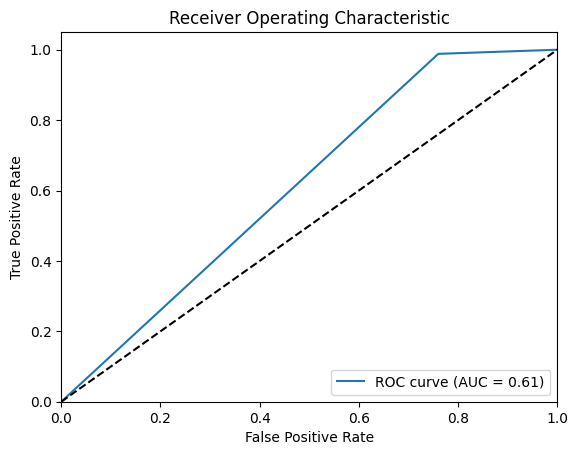

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Retired Code

In [ ]:
# model.eval()

In [ ]:
'''
for epoch in range(num_epochs):
    for batch in train_loader:
        X_train_tensor, Y_train_tensor = batch 
        outputs = model(X_train_tensor)
        loss = criterion(outputs, Y_train_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    loss_values.append(loss.item())
    
    print(f'Epoch - {epoch}, loss - {loss.item()}')
'''

"\nfor epoch in range(num_epochs):\n    for batch in train_loader:\n        X_train_tensor, Y_train_tensor = batch \n        outputs = model(X_train_tensor)\n        loss = criterion(outputs, Y_train_tensor)\n\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n        \n    loss_values.append(loss.item())\n    \n    print(f'Epoch - {epoch}, loss - {loss.item()}')\n"

In [ ]:
'''x = (range(loss_values.__len__()))

plt.plot(x, loss_values)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()'''

"x = (range(loss_values.__len__()))\n\nplt.plot(x, loss_values)\nplt.xlabel('epoch')\nplt.ylabel('loss')\nplt.show()"